in simple_test_NF_splines.ipynb, we investigated the behavious of a single spline. Now let's see how things change if we also include a global learnable parameter before we pass things through the spline!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

from activations.linearspline_slope_constraint import LinearSplineSlopeConstrained

import os
import json
from tqdm import tqdm

import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

In [2]:
def TV2(model, device_info):
    """
    Computes the sum of the TV(2) (second-order total-variation)
    semi-norm of all linearspline activations in the network.

    Returns:
        tv2 (0d Tensor):
            tv2 = sum(TV(2))
    """
    tv2 = torch.Tensor([0.]).to(device_info)

    for module in model.modules():
        if isinstance(module, LinearSplineSlopeConstrained):
            module_tv2 = module.totalVariation(mode='additive')
            tv2 = tv2 + module_tv2.norm(p=1)
    # print("tv2 is:"); print(tv2)

    return tv2[0] 

In [3]:
# Now i need to train this model using NLL loss
def nll_loss(z, det_jacobian):
    '''
    z :  tensor z in latent space
    det_jacobian : det(J_{f}(xi)) for each xi (we will take abs in this fn later)
    '''
    loss_1 = 0.5 * torch.sum(z**2)
    loss_2 = torch.sum(torch.log(torch.abs(det_jacobian) + 1e-10))
    dataset_length = z.size(0)
    loss = (loss_1-loss_2)/ dataset_length
    return loss

In [4]:
# Function to generate data from a 1D Gaussian distribution
def generate_gaussian_data(mean, 
            std_dev, total_samples, train_ratio=0.7, val_ratio=0.15):
    """
    Generate training, validation, and test datasets from a 1D Gaussian distribution.

    Parameters:
    - mean: Mean of the Gaussian distribution
    - std_dev: Standard deviation of the Gaussian distribution
    - total_samples: Total number of samples to generate
    - train_ratio: Proportion of data to use for training (default is 70%)
    - val_ratio: Proportion of data to use for validation (default is 15%)

    Returns:
    - train_data: Training set
    - val_data: Validation set
    - test_data: Test set
    """
    # Generate data
    data = np.random.normal(loc=mean, scale=std_dev, size=total_samples)

    # Shuffle data
    np.random.shuffle(data)

    # Split data based on ratios
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    return train_data, val_data, test_data

# Function to convert datasets into DataLoaders
def create_dataloaders(train_data, val_data, test_data, batch_size=32):
    """
    Convert numpy arrays into PyTorch DataLoaders.

    Parameters:
    - train_data: Training dataset (numpy array)
    - val_data: Validation dataset (numpy array)
    - test_data: Test dataset (numpy array)
    - batch_size: Batch size for the DataLoaders

    Returns:
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - test_loader: DataLoader for test data
    """
    # Convert numpy arrays to PyTorch tensors
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    test_tensor = torch.tensor(test_data, dtype=torch.float32)

    # Create TensorDatasets
    train_dataset = TensorDataset(train_tensor)
    val_dataset = TensorDataset(val_tensor)
    test_dataset = TensorDataset(test_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Example usage
mean = 1
std_dev = 2
total_samples = 50000

train_data, val_data, test_data = generate_gaussian_data(mean, std_dev, total_samples)
# Reshape data before returning
train_data = train_data.reshape(-1, 1)
val_data = val_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

# Convert to DataLoaders
batch_size = 32
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data, batch_size)

# Print dataset sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")


Training set size: 35000
Validation set size: 7500
Test set size: 7500


In [5]:
def plot_loss_curves(train_loss, val_loss,title, log_scale=False):
    ''' plots train and val loss'''
    plt.figure()
    plt.plot(train_loss,"-o" ,label="train")
    plt.plot(val_loss, "-o",label = "val")
    if log_scale:
        plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [6]:
def plot_code_distribution(model, test_loader, num_samples=1000):
    """
    Plot the code distribution obtained by applying the trained NF model to a test dataset
    and compare it to a standard normal distribution.

    Args:
    - model (NF): Trained NF model.
    - test_loader (DataLoader): DataLoader for the test dataset.
    - num_samples (int): Number of samples to visualize.

    Returns:
    None (displays the plot).
    """
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        # Concatenate multiple batches to obtain more samples
        test_samples = torch.cat([batch[0] for batch in test_loader])

        # Apply the model to the test samples
        code_samples = model(test_samples[:num_samples])

        # Convert PyTorch tensor to numpy array
        code_np = code_samples.numpy()

        # Generate samples from a standard normal distribution
        normal_samples = np.random.normal(loc=0, scale=1, size=num_samples)

        # Plot histograms of the code distribution and the standard normal distribution
        plt.figure(figsize=(10, 6))

        # Histogram for the code samples
        plt.hist(code_np, bins=25, alpha=0.7, color='blue', density=True, label="Code Distribution")

        # Histogram for the standard normal samples
        plt.hist(normal_samples, bins=25, alpha=0.7, color='orange', density=True, label="Standard Normal Distribution")

        # Add labels, legend, and title
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.title("Comparison of Code Distribution and Standard Normal Distribution")
        plt.legend()
        plt.show()


In [7]:
def plot_multiple_histogram(list_of_inputs, labels_list):
    # add a code line here: if the inputs are not numpy, convert them to numpy
    plt.figure(figsize=(10, 6))

    for i in range(0,len(list_of_inputs)):
        # Histogram for the code samples
        plt.hist(list_of_inputs[i], bins=50, alpha=0.7, 
                density=True, label=labels_list[i])
        plt.legend()

In [8]:
def plot_coefficients_evolution(num_coeffs,coeffs, slope_constr_coeffs, log_scale=0):
    ''' 
    coeffs= List[list]: 
        e.g. [ [c1(t0),c2(t0),c3(t0)], [c1(t1),c2(t1),c3(t1)] ,..., 
        [c1(tn),c2(tn),c3(tn)]]
    slope_constr_coeffs = List[list]
    
    '''
    plt.figure(figsize=(10, 6))

    for i in range(0,num_coeffs):
        plt.plot(coeffs[:,i],"-o",label=f"coeff[{i}]")
        plt.plot(slope_constr_coeffs[:,i],":o",label=f"slope constr coeff[{i}]")
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    if log_scale:
        plt.yscale("log")
    plt.xlabel("training epochs")
    plt.ylabel("coefficient values")
    plt.grid(1)
    plt.title("Evolution of coefficients with training of a spline")
    plt.tight_layout()


In [9]:
# let's try to learn a global scaling factor as well.
# we need to define a model whose first layer introduces a global scaling factor 
# and the second layer is the neural spline slope constrained activation function.

import torch
import torch.nn as nn

# Assuming LinearSplineSlopeConstrained is defined
class GlobalScalarPlusSpline(nn.Module):
    def __init__(self, initial_scalar=1.0, spline_params=None):
        """
        Args:
            initial_scalar (float): Initial value for the scalar multiplier.
            spline_params (dict): Parameters for the LinearSplineSlopeConstrained class.
        """
        super(GlobalScalarPlusSpline, self).__init__()
        
        # Initialize the scalar as a learnable parameter
        self.scalar = nn.Parameter(torch.tensor(initial_scalar, dtype=torch.float32))
        # self.bias =  nn.Parameter(torch.tensor(1, dtype=torch.float32)) 
        self.scalar2 = nn.Parameter(torch.tensor(initial_scalar, dtype=torch.float32))
        
        # Initialize the neural spline activation function inside the model
        if spline_params is None:
            raise ValueError("spline_params must be provided.")
        self.activation = LinearSplineSlopeConstrained(**spline_params)

    def forward(self, x):
        """
        Forward pass through the scalar multiplier and neural spline activation.
        Args:
            x (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Output tensor.
        """
        # # Step 1: Multiply input with scalar parameter
        scaled_input = x * self.scalar

        # # Step 2: Pass through the neural spline activation function
        output = self.activation(scaled_input)

        # #step 3
        # scaled_output = output * self.scalar2

        # return scaled_output
        return output


In [10]:
def train_and_evaluate(
    model, train_loader, val_loader, 
    lambda_tv2=1e-4, num_epochs=10, 
    lr=0.001, print_after=1, tv2_regulation=False, 
    scheduler_type="StepLR", step_size=5, gamma=0.1,
    track_coefficients=False
):
    """
    Train the model with scalar and spline activation and evaluate on a validation dataset.

    Args:
    - model: The model with scalar and spline activation.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - lr (float): Learning rate for the optimizer.
    - print_after (int): Number of epochs after which to print the training and validation loss.
    - scheduler_type (str): Type of scheduler to use ("StepLR", "ExponentialLR", etc.).
    - step_size (int): Step size for the StepLR scheduler (if applicable).
    - gamma (float): Multiplicative factor for learning rate decay.
    - track_coefficients (bool): Whether to track the coefficients of the spline activation.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    - (Optional) coeffs_evol, slope_const_coeffs_evol if track_coefficients=True.
    """
    import torch.optim as optim
    from tqdm import tqdm

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define the scheduler
    if scheduler_type == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == "ExponentialLR":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif scheduler_type == "ReduceLROnPlateau":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=gamma, patience=2)
    else:
        raise ValueError("Unsupported scheduler type. Choose from 'StepLR', 'ExponentialLR', or 'ReduceLROnPlateau'.")

    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses
    if track_coefficients:
        coeffs_evol = []
        slope_const_coeffs_evol = []

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        total_train_loss = 0.0

        if track_coefficients:
            # Extract coefficients of the spline activation function
            coeffs = model.activation.coefficients_vect.detach().cpu().numpy()
            slope_const_coeffs = model.activation.slope_constrained_coefficients_vect.detach().cpu().numpy()
            coeffs_evol.append(list(coeffs))
            slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Training phase
        model.train()  # Set the model to training mode
        for data in train_loader:
            inputs = data[0]  # Assuming data is a list containing the tensor [tensor()]

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Loss calculation
            ## Normal loss term
            train_loss = nll_loss(outputs, model.activation.grad_x_temp)

            ### TV2 regularization term
            if tv2_regulation:
                tv2_regul = TV2(model, model.activation.coefficients_vect.device)

            ## Total loss
            total_loss = train_loss + lambda_tv2 * tv2_regul if tv2_regulation else train_loss

            # Backward pass (gradient computation)
            total_loss.backward()

            # Update weights
            optimizer.step()
            total_train_loss += total_loss.item()

        # Step the scheduler
        if scheduler_type != "ReduceLROnPlateau":
            scheduler.step()
        else:
            scheduler.step(total_train_loss / len(train_loader))

        # Average training loss for the epoch
        average_train_loss = total_train_loss / len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode
            total_val_loss = 0.0
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data[0]

                    # Forward pass for validation
                    val_outputs = model(val_inputs)

                    # Loss calculation for validation
                    val_loss = nll_loss(val_outputs, model.activation.grad_x_temp)
                    total_val_loss += val_loss.item()

            # Average validation loss for the epoch
            average_val_loss = total_val_loss / len(val_loader)

            # Print training and validation losses together
            if (epoch + 1) % print_after == 0:
                print(
                    f"Epoch {epoch + 1}/{num_epochs}, "
                    f"Training Loss: {average_train_loss}, "
                    f"Validation Loss: {average_val_loss}, "
                    f"LR: {scheduler.get_last_lr()[0]},"
                )

            # Append losses to the lists
            train_losses.append(average_train_loss)
            val_losses.append(average_val_loss)

        # Reset model to training mode
        model.train()

    print("Training complete")

    if track_coefficients:
        return train_losses, val_losses, coeffs_evol, slope_const_coeffs_evol
    return train_losses, val_losses


In [109]:
### let's now define our model
spline_params = {
    "mode": "fc",
    "num_activations": 1,
    "size": 5,
    "range_": 10,
    "grid_values": torch.tensor([-6.3, -4, 2.7, 4.5, 6.5]),
    "init": "relu",
    "smin": 0.001,
    "smax": 1 / 0.001,
    "slope_constrained": True,
}

# Instantiate the model with internal activation function
model = GlobalScalarPlusSpline(initial_scalar=1.0, spline_params=spline_params)

# check the parameters:
print("parameters are:")
for name, param in model.named_parameters():
    print(name, param.shape, param.requires_grad)


initial nodal_val_locs: tensor([[-6.3000, -4.0000,  2.7000,  4.5000,  6.5000]])
initial fn values: Parameter containing:
tensor([0.0000, 0.0000, 2.7000, 4.5000, 6.5000], requires_grad=True)
parameters are:
scalar torch.Size([]) True
scalar2 torch.Size([]) True
activation.coefficients_vect torch.Size([5]) True


d:\Desktop\lipschitz_network_third_sem\Lipschitz_DSNN\activations\linearspline_slope_constraint.py:189: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.nodal_val_loc_tensor = torch.tensor(grid_values).expand((num_activations, size))


In [110]:
train_losses, val_losses, coeffs_evol, slope_const_coeffs_evol= train_and_evaluate(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                num_epochs=10,
                lr=0.0005,
                print_after=1,
                scheduler_type='ReduceLROnPlateau',
                track_coefficients=True)


Training Progress:  10%|█         | 1/10 [00:09<01:23,  9.26s/it]

Epoch 1/10, Training Loss: 2.6650567892700487, Validation Loss: 1.9633630970691114, LR: 0.0005,


Training Progress:  20%|██        | 2/10 [00:18<01:12,  9.07s/it]

Epoch 2/10, Training Loss: 1.5854715081629849, Validation Loss: 1.27981828577975, LR: 0.0005,


Training Progress:  30%|███       | 3/10 [00:27<01:02,  8.98s/it]

Epoch 3/10, Training Loss: 1.112466207152093, Validation Loss: 0.9979702744078129, LR: 0.0005,


Training Progress:  40%|████      | 4/10 [00:38<00:58,  9.79s/it]

Epoch 4/10, Training Loss: 0.9559331299291014, Validation Loss: 0.9336676526576915, LR: 0.0005,


Training Progress:  50%|█████     | 5/10 [00:47<00:49,  9.81s/it]

Epoch 5/10, Training Loss: 0.9297990180020794, Validation Loss: 0.9286508846790232, LR: 0.0005,


Training Progress:  60%|██████    | 6/10 [00:58<00:40, 10.20s/it]

Epoch 6/10, Training Loss: 0.9291548970848377, Validation Loss: 0.9297854550341342, LR: 0.0005,


Training Progress:  70%|███████   | 7/10 [01:09<00:31, 10.34s/it]

Epoch 7/10, Training Loss: 0.9302164511227302, Validation Loss: 0.9304913924095478, LR: 0.0005,


Training Progress:  80%|████████  | 8/10 [01:18<00:19,  9.99s/it]

Epoch 8/10, Training Loss: 0.930547187979958, Validation Loss: 0.9305701263407443, LR: 0.0005,


Training Progress:  90%|█████████ | 9/10 [01:28<00:09,  9.81s/it]

Epoch 9/10, Training Loss: 0.9305726097423372, Validation Loss: 0.9305738205605365, LR: 5e-05,


Training Progress: 100%|██████████| 10/10 [01:38<00:00,  9.85s/it]

Epoch 10/10, Training Loss: 0.9305738210133269, Validation Loss: 0.9305738205605365, LR: 5e-05,
Training complete


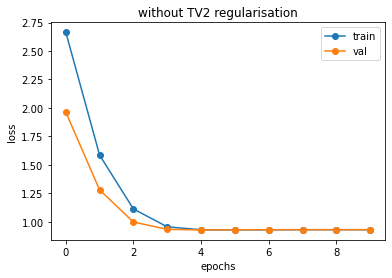

In [111]:
# let's plot the results and see how it works
plot_loss_curves(train_losses, val_losses, 
                title="without TV2 regularisation",
                )

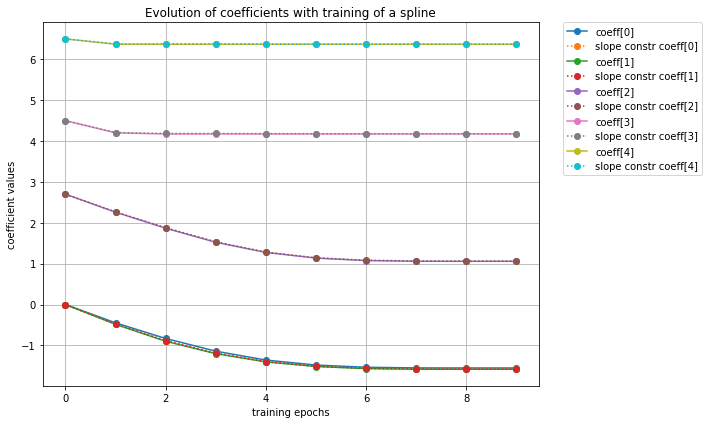

In [112]:
plot_coefficients_evolution(num_coeffs=5,coeffs=np.array(coeffs_evol),
                            slope_constr_coeffs=np.array(slope_const_coeffs_evol),
                            )

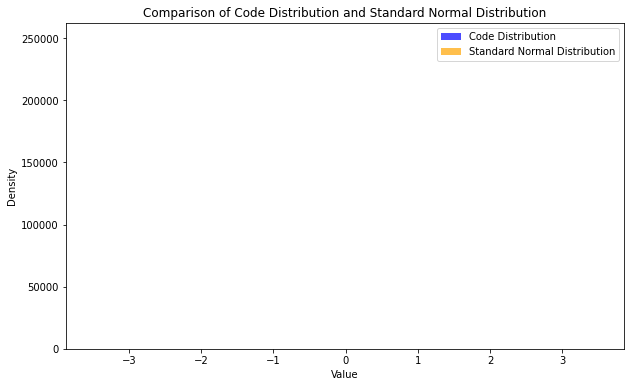

In [115]:
plot_code_distribution(model=model, 
                    test_loader=test_loader,
                    num_samples=len(test_data))

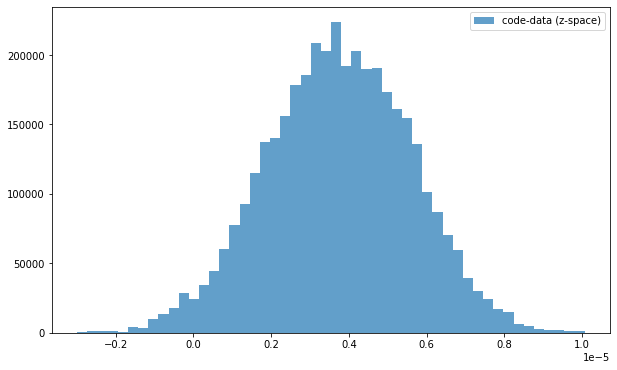

In [116]:
test_op_without_tv2 =  model(torch.tensor(test_data))
plot_multiple_histogram([test_op_without_tv2.detach().numpy()], 
                        labels_list=["code-data (z-space)"])

It did not work. It simply learned the global coefficient as 0. it kinda makes sense as this would lead to $z^{2}$ term in the loss becoming as low as possible! When i included the global scalar factor before and after the activation function, then the one after activation reduced to 0 (owing to the same reason I feel)!